## CampaignChannel A vs B

###### Business question: 
Which marketing channel produces a higher conversion rate — e.g., Social Media vs Email Marketing?
###### Goal:
Increase conversion rate (binary Conversion column: 1 = converted, 0 = not) with statistically valid evidence before rolling out changes

###### Hypothesis & metrics

Hypothesis (two-sided):

H0: Conversion rate_A = Conversion rate_B

H1: Conversion rate_A ≠ Conversion rate_B

* Primary metric:
Conversion Rate (Conversion) per user in each CampaignChannel.
* Secondary metrics to monitor:
EmailClicks, EmailOpens, AdSpend per conversion, ConversionRate (if available at campaign level), and any quality metrics (e.g., PreviousPurchases, LoyaltyPoints) to check negative side effects.

###### Experiment design choices (what I’ll assume)

CampaignChannel :  "Social Media" and "Email"

Significance level α = 0.05 (two-tailed).

Power = 0.8 (80%).

Minimum Detectable Effect (MDE):  (0.05 absolute)

###### Loading Libraries

In [24]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import NormalIndPower
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

###### Loading dataset

In [7]:
data = pd.read_csv("digital_marketing_campaign_dataset - digital_marketing_campaign_dataset.csv.csv")

In [8]:
data.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchases    8000 non-null   i

In [10]:
# creating a copy
df = data.copy()

In [11]:
df.head(2)

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1


###### Parameters

In [12]:
channel_A = "Social Media"   
channel_B = "Email"           

alpha = 0.05      
power = 0.8       
mde = 0.05  

In [13]:
# keeping only rows where channel type is one of the two groups
df_ab = df[df['CampaignChannel'].isin([channel_A, channel_B])].copy()
if df_ab.empty:
    raise ValueError("No rows matching channel_A and channel_B. Check the strings used for channel names.")

In [14]:
# verifying df_ab
df_ab.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
5,8005,25,Female,42925,Social Media,Awareness,9579.388247,0.153795,0.161316,6,2.125850,7.752831,95,5,8,0,3316,IsConfid,ToolConfid,1
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.052878,0.188946,48,2.626015,2.987817,96,9,3,0,2983,IsConfid,ToolConfid,1
8,8008,36,Female,140788,Email,Retention,9421.250951,0.023536,0.112585,13,5.472843,14.287421,73,4,8,5,460,IsConfid,ToolConfid,1


###### Group size

In [15]:
group_counts = df_ab['CampaignChannel'].value_counts()
print("Group counts:\n", group_counts)

Group counts:
 Email           1557
Social Media    1519
Name: CampaignChannel, dtype: int64


Insight:
Both groups have similar sample sizes - balanced design

###### Conversion count and rate

In [16]:
conv_summary = df_ab.groupby('CampaignChannel')['Conversion'].agg(['sum','count'])
conv_summary['conv_rate'] = conv_summary['sum'] / conv_summary['count']
print("\nConversion summary:\n", conv_summary)


Conversion summary:
                   sum  count  conv_rate
CampaignChannel                        
Email            1355   1557   0.870263
Social Media     1319   1519   0.868334


Insight: 
* Email is +0.19 percentage-points higher
* The difference is tiny (0.87% vs 0.868%)

###### Pre-experiment checks

In [17]:
# Check balance on key covariates (Age, Gender, Income, PreviousPurchases, LoyaltyPoints)

def balance_table(df_ab, group_col, numeric_cols, cat_cols=None):
    out = {}
    groups = df_ab[group_col].unique()
    for col in numeric_cols:
        stats = df_ab.groupby(group_col)[col].agg(['mean','std','median','count']).T
        out[col] = stats
    if cat_cols:
        for col in cat_cols:
            tab = pd.crosstab(df_ab[group_col], df[col], normalize='index')
            out[col] = tab
    return out

numeric_cols = ['Age','Income','WebsiteVisits','TimeOnSite','PreviousPurchases','LoyaltyPoints']
cat_cols = ['Gender','CampaignType','AdvertisingPlatform']
balance = balance_table(df_ab, 'CampaignChannel', numeric_cols, cat_cols)

# Print numeric balance
for k,v in balance.items():
    print("\n===", k, "===\n", v)



=== Age ===
 CampaignChannel        Email  Social Media
mean               43.041105     43.487821
std                14.890504     14.576171
median             42.000000     43.000000
count            1557.000000   1519.000000

=== Income ===
 CampaignChannel         Email  Social Media
mean             82946.919717  85691.835418
std              37611.724861  37600.437082
median           81196.000000  86285.000000
count             1557.000000   1519.000000

=== WebsiteVisits ===
 CampaignChannel        Email  Social Media
mean               24.878613     25.125741
std                14.179579     14.256334
median             25.000000     25.000000
count            1557.000000   1519.000000

=== TimeOnSite ===
 CampaignChannel        Email  Social Media
mean                7.679983      7.852198
std                 4.223295      4.275964
median              7.659507      7.752831
count            1557.000000   1519.000000

=== PreviousPurchases ===
 CampaignChannel        Email  S

###### Insight
Age, Income, WebsiteVisits, TimeOnSite, PreviousPurchases, LoyaltyPoints
 Both groups have almost identical means and medians.
 No sign of selection bias.

Categorical Variables

Gender, CampaignType, AdvertisingPlatform
 Distribution is very similar across both groups.

###### Interpretation:
The experiment groups are balanced - No confounding - Comparisons are valid.

#### Sample size determination

In [18]:
# Baseline conversion

baseline = conv_summary['sum'].sum() / conv_summary['count'].sum()
baseline_A = conv_summary.loc[channel_A, 'conv_rate']
baseline_B = conv_summary.loc[channel_B, 'conv_rate']

print("Baseline overall:", baseline)
print(f"Baseline {channel_A}:", baseline_A)
print(f"Baseline {channel_B}:", baseline_B)

Baseline overall: 0.8693107932379714
Baseline Social Media: 0.8683344305464121
Baseline Email: 0.8702633269107257


Enough sample to detect the target MDE

In [19]:
# Computing sample size with normal power

analysis = NormalIndPower()
effect_size = abs(mde) / np.sqrt(baseline*(1-baseline))  

# using cohen's
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

p1 = baseline
p2 = baseline + mde
h = cohens_h(p1, p2)
n_per_group = analysis.solve_power(effect_size=h, power=power, alpha=alpha, alternative='two-sided')
print(f"Estimated sample per group to detect an absolute difference of {mde:.3f}: {int(np.ceil(n_per_group))}")

Estimated sample per group to detect an absolute difference of 0.050: 586


##### Satistical test

In [20]:
# Extracting counts for z-test
successes = conv_summary['sum'].loc[[channel_A, channel_B]].values
ns = conv_summary['count'].loc[[channel_A, channel_B]].values

# z-test (two-sided)
z_stat, p_value = proportions_ztest(successes, ns, alternative='two-sided')
# Computing confidence interval for difference in proportions
p1 = successes[0] / ns[0]
p2 = successes[1] / ns[1]
diff = p2 - p1

# Approximate standard error and 95% CI for difference
se = np.sqrt(p1*(1-p1)/ns[0] + p2*(1-p2)/ns[1])
from math import sqrt
z_crit = 1.96
ci_lower = diff - z_crit*se
ci_upper = diff + z_crit*se

print(f"\nZ-statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Conversion {channel_A}: {p1:.4%} (n={ns[0]})")
print(f"Conversion {channel_B}: {p2:.4%} (n={ns[1]})")
print(f"Absolute lift (B - A): {diff:.4%}")
print(f"95% CI for difference: [{ci_lower:.4%}, {ci_upper:.4%}]")



Z-statistic: -0.1587
p-value: 0.8739
Conversion Social Media: 86.8334% (n=1519)
Conversion Email: 87.0263% (n=1557)
Absolute lift (B - A): 0.1929%
95% CI for difference: [-2.1898%, 2.5756%]


###### Interpretation

p = 0.874 > 0.05 - Fail to reject H₀

The difference between Email and Social Media is not statistically significant.

The 95% CI includes zero - effect could be positive or negative.

###### Conclusion: 
There is no measurable uplift in conversions from Email vs. Social Media

###### Effect size and business impact

In [21]:
# Relative lift
rel_lift = diff / p1 if p1 > 0 else np.nan
print(f"Relative lift: {rel_lift:.2%}")

# Cost per conversion by channel
spend_summary = df_ab.groupby('CampaignChannel').agg({'AdSpend':'sum', 'Conversion':'sum'})
spend_summary['cost_per_conv'] = spend_summary['AdSpend'] / spend_summary['Conversion'].replace(0, np.nan)
print("\nAd spend and cost per conversion:\n", spend_summary)


Relative lift: 0.22%

Ad spend and cost per conversion:
                       AdSpend  Conversion  cost_per_conv
CampaignChannel                                         
Email            7.871576e+06        1355    5809.281071
Social Media     7.542323e+06        1319    5718.213229


###### Insight
* Absolute lift: +0.1929%
* Relative lift: +0.22%
* Lift is negligible and within noise range
* The true effect could be anywhere from −2.19% to +2.58%

###### Adspend
* Social Media gives slightly cheaper conversions

* Difference ≈ $91 cheaper per conversion

* But since conversion rates are similar, cost efficiency becomes more important.
* Social Media is slightly more cost-efficient.

###### Secondary metric and safety check

In [22]:
# Comparing average loyalty / previous purchases among converted users by channel

converts = df_ab[df_ab['Conversion'] == 1]
quality_by_channel = converts.groupby('CampaignChannel')[['PreviousPurchases',
                                                          'LoyaltyPoints',
                                                          'Income']].agg(['mean','count'])

print("\nQuality metrics among converters:\n", quality_by_channel)



Quality metrics among converters:
                 PreviousPurchases       LoyaltyPoints              Income  \
                             mean count          mean count          mean   
CampaignChannel                                                             
Email                    4.664945  1355   2567.024354  1355  83859.695203   
Social Media             4.609553  1319   2585.078089  1319  85940.220622   

                       
                count  
CampaignChannel        
Email            1355  
Social Media     1319  


Converting users are similar in quality across both channels.

###### Visualizations

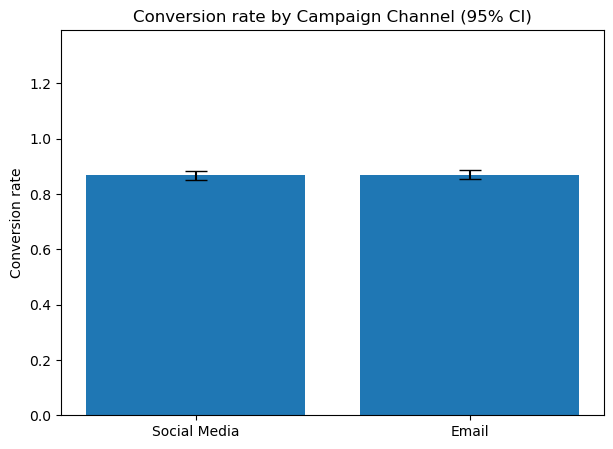

In [23]:
# Bar chart of conversion rates with 95% CI

channels = [channel_A, channel_B]
rates = [p1, p2]
se_rates = [np.sqrt(rates[0]*(1-rates[0])/ns[0]), np.sqrt(rates[1]*(1-rates[1])/ns[1])]
ci_lows = [rates[i] - 1.96*se_rates[i] for i in range(2)]
ci_highs = [rates[i] + 1.96*se_rates[i] for i in range(2)]

plt.figure(figsize=(7,5))
plt.bar(channels, rates, yerr=[(rates[i]-ci_lows[i], ci_highs[i]-rates[i]) for i in range(2)],
        capsize=8)

plt.ylabel('Conversion rate')
plt.title('Conversion rate by Campaign Channel (95% CI)')
plt.ylim(0, max(rates)*1.6)
plt.show()


###### Rechecking with statsmodels


In [25]:
# Creating  binary indicator: 1 if channel_B, 0 if channel_A

df_ab = df_ab[df_ab['CampaignChannel'].isin([channel_A, channel_B])]
df_ab['is_B'] = (df_ab['CampaignChannel'] == channel_B).astype(int)
model = smf.logit('Conversion ~ is_B + Age + Income + C(Gender)', data=df_ab).fit(disp=False)
print(model.summary())


                           Logit Regression Results                           
Dep. Variable:             Conversion   No. Observations:                 3076
Model:                          Logit   Df Residuals:                     3071
Method:                           MLE   Df Model:                            4
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                0.002570
Time:                        00:04:03   Log-Likelihood:                -1189.5
converged:                       True   LL-Null:                       -1192.5
Covariance Type:            nonrobust   LLR p-value:                    0.1896
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.4625      0.214      6.831      0.000       1.043       1.882
C(Gender)[T.Male]     0.0790      0.110      0.718      0.473      -0.137       0.295
is_B                  0.

###### Key Result:

* is_B (Email): coef = 0.0295, p = 0.784
 Again NOT significant
Even after controlling for demographics, Email does not outperform Social Media.

* Regression confirms the A/B test result.

###### Final Business Interpretation
No statistically significant difference

Both channels perform equally well in conversion outcomes.

Cost-efficiency slightly favors Social Media

Even though conversion rates are similar:

Social Media achieves conversions at lower cost

That makes it the better ROI channel

User quality is identical

No channel sends lower-value customers.

###### Final Recommendation
Do not switch channels based on conversion rate alone

Because the difference is statistically insignificant.

Optimize budget toward Social Media

Because:

Conversion rates are equal

Cost per conversion is cheaper

Large-scale switching has lower financial risk

Future Experiments to Run

To get actionable improvements:

A/B test creative versions (images, CTAs)

A/B test targeting strategies

A/B test frequency / impression caps

A/B test ad personalization

Use multi-channel attribution to measure cross-channel lift